# W2V MLP

### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import optuna
import random

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from spacy.lang.de.stop_words import STOP_WORDS

import mlflow
import mlflow.pytorch

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# If using CUDA
torch.cuda.manual_seed_all(seed)

# Define experiment
mlflow.set_experiment("W2V")
mlflow.pytorch.autolog()

BENCHMARK_TABLE = "../../class_bench.parquet"

%load_ext autoreload
%autoreload 2

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/05/07 09:38:00 INFO mlflow.tracking.fluent: Experiment with name 'W2V' does not exist. Creating a new experiment.


### all functions

In [2]:
from torch.utils.data import Dataset, WeightedRandomSampler
import torch
import numpy as np
from collections import Counter
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import time
import pickle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class PoemDataset(Dataset):
    def __init__(self, X_seqs, y, max_len):
        self.X = [self._pad(x, max_len) for x in X_seqs]
        self.y = y
        self.max_len = max_len

    def _pad(self, seq, max_len):
        if len(seq) >= max_len:
            return np.array(seq[:max_len])
        pad = np.zeros((max_len - len(seq), len(seq[0])))
        return np.vstack((seq, pad))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long),
        )


def get_weighted_sampler(y):
    class_counts = Counter(y)
    weights = [1.0 / class_counts[label] for label in y]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


class PoemRNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, h_n = self.rnn(x)  # h_n: [1, batch, hidden_dim]
        return self.fc(h_n.squeeze(0))


def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix_percent(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    df_cm = pd.DataFrame(cm_percent, index=label_names, columns=label_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.show()


def sequence_vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return vectors  # List of np.array, shape = (word_count, embedding_dim)


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        attn_weights = torch.softmax(self.attn(x), dim=1)  # (batch_size, seq_len, 1)
        weighted_sum = torch.sum(attn_weights * x, dim=1)  # (batch_size, hidden_dim)
        return weighted_sum


class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,  # applies dropout between stacked layers
        )
        self.layernorm = nn.LayerNorm(hidden_dim * 2)  # for BiLSTM output
        self.attention = Attention(hidden_dim * 2)

        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim * 2)
        norm_out = self.layernorm(lstm_out)  # stabilize across time steps
        norm_out = self.dropout(norm_out)  # prevent overfitting
        attn_out = self.attention(norm_out)  # (batch_size, hidden_dim * 2)
        out = torch.relu(self.fc1(attn_out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out


class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_wts = None

    def __call__(self, val_metric, model):
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"🛑 EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0


def train_rnn(model, train_loader, loss_fn, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()

        # Training phase
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions.double() / total_samples
        print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")

        # Step the scheduler
        scheduler.step(epoch_loss)

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        # Early stopping
        early_stopping(epoch_acc, model)
        if early_stopping.early_stop:
            print("🌙 Early stopping triggered")
            # If early stopping was triggered, use its best weights
            if early_stopping.best_model_wts is not None:
                best_model_wts = early_stopping.best_model_wts
            break

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, total_time


def validate_rnn(model, test_loader, training_time=None):
    """
    Validate the RNN model using test data.

    Args:
        model: The trained RNN model
        test_loader: The test data loader (from your notebook)
        training_time: Optional training time for reporting total time

    Returns:
        tuple: (recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc)
    """
    model.eval()
    start_time = time.time()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Get unique classes for labels
    classes = np.unique(all_labels)
    class_names = [str(c) for c in classes]

    # 1. Basic Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision_avg = precision_score(all_labels, all_predictions, average="weighted")
    recall_avg = recall_score(all_labels, all_predictions, average="weighted")
    f1_score_avg = f1_score(all_labels, all_predictions, average="weighted")

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=classes)
    cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # 3. Specificity (True Negative Rate)
    specificity = []
    for i in range(len(classes)):
        tn = np.sum((all_labels != i) & (all_predictions != i))
        fp = np.sum((all_labels != i) & (all_predictions == i))
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    avg_specificity = np.mean(specificity)

    # 4. ROC and AUC
    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # One-vs-Rest ROC curves
    for i in range(len(classes)):
        # Convert to binary classification for each class
        y_true_binary = (all_labels == i).astype(int)
        y_score = all_probs[:, i]

        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve and ROC area
    # First, binarize the labels
    y_true_bin = np.zeros((len(all_labels), len(classes)))
    for i in range(len(all_labels)):
        y_true_bin[i, all_labels[i]] = 1

    # Calculate micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    avg_roc = roc_auc["micro"]

    validation_time = time.time() - start_time

    # Print metrics
    print("\n=== Test Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1-Score: {f1_score_avg:.4f}")
    print(f"Specificity: {avg_specificity:.4f}")
    print(f"AUC (micro): {avg_roc:.4f}")
    print(f"Test time: {validation_time:.2f}s")
    if training_time is not None:
        print(f"Training time: {training_time:.2f}s")
        print(f"Total time (train + test): {training_time + validation_time:.2f}s")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (area = {avg_roc:.2f})",
    )

    for i in range(len(classes)):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.show()

    # Print Classification Report
    print("\n=== Classification Report ===")
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
    )
    print(report)

    return recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc


def save_model(model, model_path="model/saved/rnn_model.pkl"):
    """
    Save the RNN model using pickle format.

    Args:
        model: The trained RNN model to save
        model_path: Path where to save the model (default: model/saved/rnn_model.pkl)
    """
    # Prepare data to save
    save_data = {
        "model_state_dict": model.state_dict(),
        "model_config": {
            "input_dim": model.lstm.input_size,
            "hidden_dim": model.lstm.hidden_size,
            "num_classes": model.fc2.out_features,
            "dropout": model.dropout.p if hasattr(model, "dropout") else 0.0,
        },
    }

    # Save using pickle
    with open(model_path, "wb") as f:
        pickle.dump(save_data, f)
    print(f"RNN model saved successfully to {model_path}")


def load_model(model_path="model/saved/rnn_model.pkl"):
    """
    Load a saved RNN model from pickle format.

    Args:
        model_path: Path to the saved model (default: model/saved/rnn_model.pkl)

    Returns:
        model: The loaded RNN model
    """
    # Load checkpoint using pickle
    with open(model_path, "rb") as f:
        checkpoint = pickle.load(f)

    # Create model with saved configuration
    config = checkpoint["model_config"]
    model = BiLSTMWithAttention(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        num_classes=config["num_classes"],
        dropout=config["dropout"],
    )

    # Load model weights
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    return model


Using device: cpu


### Loading data into a Dataframe (df)

In [6]:
df = pd.read_parquet("data/de_poems.parquet")
df = df.astype(
    {"title": "string", "text": "string", "author": "string", "creation": "int64"}
)
df.dtypes


title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [7]:
# Convertir les dates en siècles, en gérant les valeurs None
# D'abord, créer une copie pour ne pas modifier l'original
df_siecles = df.copy()

# Convertir uniquement les valeurs non-nulles en entiers puis en siècles
# Assurons-nous que toutes les valeurs sont soit des nombres, soit des NaN
df_siecles["creation"] = pd.to_numeric(df_siecles["creation"], errors="coerce")

# Maintenant, appliquer la conversion en siècles seulement sur les valeurs non-nulles
mask = df_siecles["creation"].notna()
df_siecles.loc[mask, "creation"] = df_siecles.loc[mask, "creation"].apply(
    lambda x: (x - 1) // 100 + 1
)

# Remplacer df par df_siecles pour conserver les modifications
df = df_siecles

In [8]:
# Filtrer les lignes où creation est None
df_none_creation = df[df["creation"].isnull()]


# Grouper par author pour voir combien de poèmes chaque author a avec creation = None
authors_avec_none = (
    df_none_creation.groupby("author").size().sort_values(ascending=False)
)

# Pour chaque author ayant des poèmes sans date, vérifier s'il a aussi des poèmes avec date
authors_a_corriger = []
for author in df_none_creation["author"].unique():
    dates_disponibles = df[df["author"] == author]["creation"].dropna().unique()
    if len(dates_disponibles) > 0:
        authors_a_corriger.append((author, dates_disponibles))


# Fonction pour remplir les dates manquantes avec la médiane des dates de l'author
def remplir_dates_manquantes(df):
    df_copy = df.copy()

    for author in df[df["creation"].isna()]["author"].unique():
        dates = df[df["author"] == author]["creation"].dropna()
        if len(dates) > 0:
            # Utiliser la médiane des dates disponibles pour cet author
            date_mediane = int(np.median(dates))
            # Remplir les valeurs manquantes pour cet author
            mask = (df_copy["author"] == author) & (df_copy["creation"].isna())
            df_copy.loc[mask, "creation"] = date_mediane

    return df_copy


# Appliquer la fonction pour remplir les dates manquantes
df_corrige = remplir_dates_manquantes(df)

# Vérifier combien de dates ont été corrigées
nb_corriges = len(df) - df_corrige["creation"].isna().sum()
nb_restants = df_corrige["creation"].isna().sum()

print(f"\nNombre de dates corrigées: {nb_corriges - (len(df) - len(df_none_creation))}")
print(f"Nombre de poèmes restants sans date: {nb_restants}")

df = df_corrige.dropna()


Nombre de dates corrigées: 0
Nombre de poèmes restants sans date: 0


### Tokenizing text

#### Spacy

In [32]:
nlp = spacy.load("de_core_news_sm")
# python -m spacy download de_core_news_sm


def preprocess_text_spacy(doc):
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens


def preprocess_text_spacy_stopwords(doc):
    filtered_tokens = [
        token.lemma_
        for token in doc
        if not token.is_punct and token.lemma_.lower() not in STOP_WORDS
    ]
    return filtered_tokens


In [33]:
texts = df["text"].tolist()
docs = list(nlp.pipe(texts, batch_size=1000, n_process=4))

df["tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]

In [ ]:
df.to_pickle("spacy_tokenized.pkl")

In [3]:
df = pd.read_pickle("../../multi_layer_perceptron/spacy_tokenized.pkl")

### Training Word 2 Vec on the tokenized texts

In [ ]:
tokenized_poems = df["tokens"].tolist()
model_df = Word2Vec(tokenized_poems, vector_size=100, window=5, min_count=2, workers=4)

model_df.save("word2vec_df.model")

#### W2V Boosted

In [35]:
model_df = Word2Vec(
    sentences=df["tokens"],
    vector_size=500,
    window=20,
    min_count=2,
    workers=32,
    epochs=50,
    seed=42,
)

model_df.save("word2vec_boosted2.model")

In [4]:
model_df = Word2Vec.load("../../multi_layer_perceptron/word2vec_boosted2.model")

## RNN

In [5]:
df["sequence_embedding"] = df["tokens"].apply(lambda x: sequence_vectorize(x, model_df))

In [6]:
# Create a mapping from century to zero-indexed labels
century_to_idx = {
    century: idx for idx, century in enumerate(sorted(df["creation"].unique()))
}
print("Century to index mapping:", century_to_idx)

Century to index mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


In [7]:
# Create new column with zero-indexed labels
df["century_label"] = df["creation"].map(century_to_idx)

In [8]:
from sklearn.model_selection import train_test_split

X_embedded = df["sequence_embedding"].tolist()  # List of lists of word2vec vectors (np.ndarray)
y = df["century_label"].tolist()  # List of ints

# Set params
max_len = 50
embedding_dim = X_embedded[0][0].shape[0]
hidden_dim = 128
num_classes = len(set(y))
batch_size = 32
epochs = 100

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_embedded, y, stratify=y, test_size=0.2, random_state=42
)

# Datasets
train_dataset = PoemDataset(X_train, y_train, max_len)
test_dataset = PoemDataset(X_test, y_test, max_len)

# Sampler for imbalance
sampler = get_weighted_sampler(y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# convert y from list to tensor
y = torch.tensor(y, dtype=torch.long)

# Calculate class weights based on the labels in your dataset
class_weights = compute_class_weight(
    "balanced", classes=torch.unique(y).numpy(), y=y.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Create the loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [10]:
# Example of running the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMWithAttention(
    input_dim=embedding_dim, hidden_dim=128, num_classes=num_classes, dropout=0.3
).to(device)

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# Call train_model
model, rnn_training_time = train_rnn(
    model, train_loader, loss_fn, optimizer, scheduler, num_epochs=50
)

Epoch 1/50
Training Loss: 0.0329 | Training Accuracy: 0.6975
Epoch 2/50
Training Loss: 0.0080 | Training Accuracy: 0.8010
Epoch 3/50
Training Loss: 0.0035 | Training Accuracy: 0.8498
Epoch 4/50
Training Loss: 0.0036 | Training Accuracy: 0.8537
Epoch 5/50
Training Loss: 0.0021 | Training Accuracy: 0.8842
Epoch 6/50
Training Loss: 0.0052 | Training Accuracy: 0.8528
🛑 EarlyStopping counter: 1 / 5
Epoch 7/50
Training Loss: 0.0019 | Training Accuracy: 0.8942
Epoch 8/50
Training Loss: 0.0044 | Training Accuracy: 0.8823
🛑 EarlyStopping counter: 1 / 5
Epoch 9/50
Training Loss: 0.0019 | Training Accuracy: 0.8967
Epoch 10/50
Training Loss: 0.0022 | Training Accuracy: 0.9009
Epoch 11/50
Training Loss: 0.0021 | Training Accuracy: 0.8948
🛑 EarlyStopping counter: 1 / 5
Epoch 12/50
Training Loss: 0.0015 | Training Accuracy: 0.9115
Epoch 13/50
Training Loss: 0.0015 | Training Accuracy: 0.9138
Epoch 14/50
Training Loss: 0.0016 | Training Accuracy: 0.9116
🛑 EarlyStopping counter: 1 / 5
Epoch 15/50
Train

In [13]:
save_model(model, "../trained/RNN_W2V_model.pkl")

RNN model saved successfully to ../trained/RNN_W2V_model.pkl


## Evaluation


=== Test Metrics ===
Accuracy: 0.7180
Precision: 0.7939
Recall: 0.7180
F1-Score: 0.7304
Specificity: 0.9601
AUC (micro): 0.9654
Test time: 19.49s
Training time: 2209.29s
Total time (train + test): 2228.78s


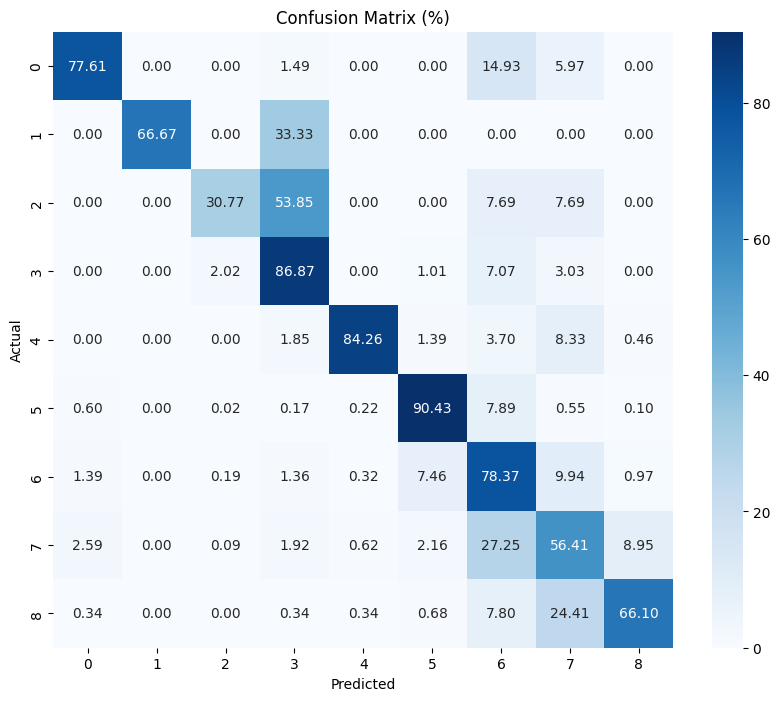

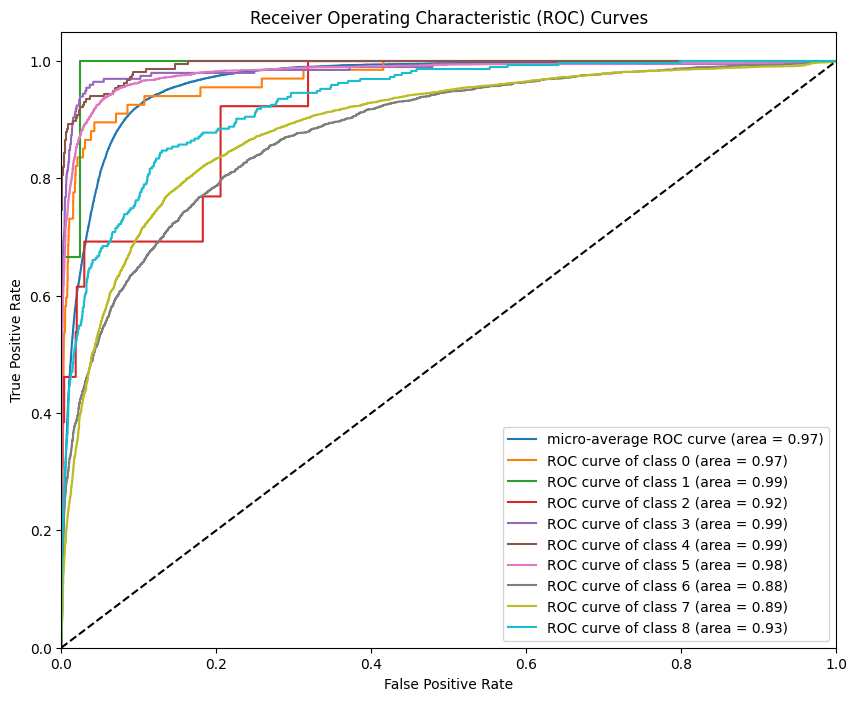


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.18      0.78      0.29        67
           1       1.00      0.67      0.80         3
           2       0.19      0.31      0.24        13
           3       0.48      0.87      0.62       198
           4       0.75      0.84      0.79       216
           5       0.91      0.90      0.91      4003
           6       0.53      0.78      0.63      3098
           7       0.89      0.56      0.69      6421
           8       0.24      0.66      0.35       295

    accuracy                           0.72     14314
   macro avg       0.58      0.71      0.59     14314
weighted avg       0.79      0.72      0.73     14314



In [12]:
recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc = validate_rnn(model, test_loader, rnn_training_time)

In [14]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)

In [15]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        NaN

In [16]:
benchmark.loc[
    ("Word2Vec", "Recurrent Neural Network"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc]


In [17]:
benchmark.to_parquet(BENCHMARK_TABLE, index=True)


In [18]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.717968       0.793872    0.717968   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.730375  0.965358   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        NaN